# NLP for Sentiment Analysis in Sports Sponsorship in Media

## Data Processor

### Keywords/Important Terms

In [35]:
core_keywords = [
    "sports sponsorship",
    "sponsorship",
    "sponsor",
    "sports partnership",
    "partnership",
    "partner",
    "brand deal",
    "collaboration",
    "endorsement"
]


activation_marketing_keywords = [
    "activation",
    "brand activation",
    "sports marketing",
    "brand collaboration",
    "co-branding",
    "influencer deal",
    "athlete ambassador",
    "brand ambassador",
    "marketing partnership",
    "promotional deal",
    "campaign partner",
    "joint marketing",
    "cross-promotion",
    "advertising deal"
]


official_sponsor_keywords = [
    "official sponsor",
    "presenting partner",
    "exclusive sponsor",
    "primary sponsor",
    "title sponsor",
    "official partner",
    "strategic partner",
    "commercial partner",
    "business partnership"
]


event_league_keywords = [
    "event partnership",
    "event sponsor",
    "league sponsor",
    "tournament sponsor",
    "media rights",
    "broadcast partnership",
    "licensing deal",
    "licensing agreement",
    "hospitality partner",
    "stadium naming",
    "naming rights"
]



buzzword_keywords = [
    "NIL deal",
    "NIL partnership",
    "athlete NIL",
    "crypto sponsorship",
    "betting sponsor",
    "esports sponsorship",
    "sustainability sponsor",
    "technology partner"
]



property_keywords = [
    "NBA sponsor",
    "NFL sponsor",
    "Olympic partner",
    "F1 sponsor",
    "jersey sponsor",
    "sports apparel deal"
]


keywords = (
    core_keywords +
    activation_marketing_keywords +
    official_sponsor_keywords +
    event_league_keywords +
    buzzword_keywords +
    property_keywords
)

keywords



#For the purposes of using a demo dataset just simply use core_keywords


['sports sponsorship',
 'sponsorship',
 'sponsor',
 'sports partnership',
 'partnership',
 'partner',
 'brand deal',
 'collaboration',
 'endorsement',
 'activation',
 'brand activation',
 'sports marketing',
 'brand collaboration',
 'co-branding',
 'influencer deal',
 'athlete ambassador',
 'brand ambassador',
 'marketing partnership',
 'promotional deal',
 'campaign partner',
 'joint marketing',
 'cross-promotion',
 'advertising deal',
 'official sponsor',
 'presenting partner',
 'exclusive sponsor',
 'primary sponsor',
 'title sponsor',
 'official partner',
 'strategic partner',
 'commercial partner',
 'business partnership',
 'event partnership',
 'event sponsor',
 'league sponsor',
 'tournament sponsor',
 'media rights',
 'broadcast partnership',
 'licensing deal',
 'licensing agreement',
 'hospitality partner',
 'stadium naming',
 'naming rights',
 'NIL deal',
 'NIL partnership',
 'athlete NIL',
 'crypto sponsorship',
 'betting sponsor',
 'esports sponsorship',
 'sustainability sp

### Import Statements

In [38]:
import pandas as pd
import time
import logging
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup


In [43]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


### Reddit API Extraction

In [46]:
import praw
def fetch_reddit_posts(keywords, limit=50, comments_limit=10):
    subreddits = [
        "sports", "sportsbiz", "sportsmarketing", "marketing", "business", "Entrepreneur",
        "nba", "nfl", "soccer", "formula1", "olympics", "mlb", "nhl", "esports",
        "brandnews", "advertising", "influencermarketing"
    ]

    #For the purposes of demo use only one subreddit
    demo_subreddits = ["sports"]
    reddit = praw.Reddit(
        client_id='uj98xZpKCRXiernnRu-DDQ',
        client_secret='KibZ1g2Da0XpfDCHtiPJDB9_XvAx4w',
        user_agent='script:SportsSentimentAnalysis:1.0 (by /u/hermantacobear)'
    )
    print('connection to reddit api made')
    posts = []
    for subreddit in demo_subreddits: #Demo loop
    #for subreddit in subreddits: #Real loop
        sub = reddit.subreddit(subreddit)
        print(f"\nSearching r/{subreddit}...")
        for kw in keywords:
            print(f"  Keyword: {kw}")
            try:
                for post in sub.search(kw, limit=limit):
                    # Get top N comments' text
                    post.comments.replace_more(limit=0)
                    comment_bodies = []
                    for i, comment in enumerate(post.comments.list()):
                        if i >= comments_limit:
                            break
                        comment_bodies.append(comment.body)
                    # Concatenate selftext + comments for a "full discussion" field
                    full_text = post.selftext + "\n" + "\n".join(comment_bodies)
                    posts.append({
                        'platform': 'reddit',
                        'subreddit': subreddit,
                        'keyword': kw,
                        'title': post.title,
                        'text': full_text,
                        'created': pd.to_datetime(post.created_utc, unit='s'),
                        'url': post.url
                    })
            except Exception as e:
                print(f"    Error searching r/{subreddit} for '{kw}': {e}")
            time.sleep(1)  # Avoid rate limits
    return pd.DataFrame(posts)


### X Scraper

In [49]:
def scrape_x_tweets(keywords, limit=50, scroll_times=5):
    import pandas as pd
    from selenium import webdriver
    from selenium.webdriver.common.by import By
    from selenium.webdriver.chrome.service import Service
    from webdriver_manager.chrome import ChromeDriverManager
    import time

    all_tweets = []
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get('https://twitter.com/login')
    input("Log in to X, then press Enter here...")

    for kw in keywords:
        search_url = f"https://twitter.com/search?q=sports%20{kw.replace(' ', '%20')}&src=typed_query"
        driver.get(search_url)
        time.sleep(4)
        for _ in range(scroll_times):
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
        tweet_elements = driver.find_elements(By.XPATH, '//article[@role="article"]')
        for tweet in tweet_elements[:limit]:
            try:
                text_elem = tweet.find_element(By.XPATH, './/div[@lang]')
                text = text_elem.text
                created = ""
                try:
                    time_elem = tweet.find_element(By.XPATH, './/time')
                    created = time_elem.get_attribute('datetime')
                except Exception:
                    pass
                all_tweets.append({
                    'platform': 'x',
                    'keyword': kw,
                    'title': '',
                    'text': text,
                    'created': created,
                    'url': ''
                })
            except Exception:
                continue
    driver.quit()
    return pd.DataFrame(all_tweets)


### Webscraper w/ SerpAPI

In [52]:
import requests
import pandas as pd

def google_news_search_serpapi(keywords, api_key, limit=100):
    all_results = []
    for kw in keywords:
        params = {
            "engine": "google",
            "q": kw + " sports sponsorship partnership",
            "tbm": "nws",
            "api_key": api_key,
            "num": limit
        }
        response = requests.get('https://serpapi.com/search', params=params)
        data = response.json()
        for article in data.get('news_results', []):
            all_results.append({
                'platform': 'news',
                'keyword': kw,
                'title': article.get('title'),
                'text': article.get('snippet'),
                'created': article.get('date'),
                'url': article.get('link')
            })
    return pd.DataFrame(all_results)


In [54]:
# Real code:
#x_df = scrape_x_tweets(keywords)
#news_df = google_news_search_serpapi(keywords, api_key="ebe79376c272ac86795c11a7b7e9707e17ac2600db96bcbd9c12800533ad59db")
#reddit_df = fetch_reddit_posts(keywords)

x_df = scrape_x_tweets(core_keywords)
news_df = google_news_search_serpapi(core_keywords, api_key="ebe79376c272ac86795c11a7b7e9707e17ac2600db96bcbd9c12800533ad59db")
reddit_df = fetch_reddit_posts(core_keywords)

all_df = pd.concat([reddit_df, x_df, news_df], ignore_index=True)
print(all_df.head())


INFO:WDM:====== WebDriver manager ======
INFO:WDM:Get LATEST chromedriver version for google-chrome
INFO:WDM:Get LATEST chromedriver version for google-chrome
INFO:WDM:Driver [/Users/rshah1309/.wdm/drivers/chromedriver/mac64/137.0.7151.68/chromedriver-mac-arm64/chromedriver] found in cache


Log in to X, then press Enter here... Enter


connection to reddit api made

Searching r/sports...
  Keyword: sports sponsorship
  Keyword: sponsorship
  Keyword: sponsor
  Keyword: sports partnership
  Keyword: partnership
  Keyword: partner
  Keyword: brand deal
  Keyword: collaboration
  Keyword: endorsement
  platform subreddit             keyword  \
0   reddit    sports  sports sponsorship   
1   reddit    sports  sports sponsorship   
2   reddit    sports  sports sponsorship   
3   reddit    sports  sports sponsorship   
4   reddit    sports  sports sponsorship   

                                               title  \
0  UFC gets a piece of sports cryptocurrency mone...   
1  Major League Baseball, pioneering CBD brand Ch...   
2  Pro cycling is the best sponsorship deal in sp...   
3  How corporate sponsorship of children's sports...   
4  Guest opinion: Companies sponsoring Olympics e...   

                                                text              created  \
0  \n[removed]\n[removed]\n[removed]\nI don't kno...  

In [ ]:
#To use instead of running code again, load from dataset

#all_df = pd.read_csv('output.csv') #read data
#all_df

In [56]:
#saving to dataset just to not lose progress

all_df.to_csv('output.csv') #save data

In [ ]:
#!pip install transformers torch --quiet

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_tfidf = vectorizer.fit_transform(all_df['text'].astype(str).fillna(''))
print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (1291, 500)


In [60]:
from transformers import pipeline

sentiment_pipe = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
all_df['bert_sentiment'] = all_df['text'].astype(str).fillna('').apply(lambda x: sentiment_pipe(x[:512])[0]['label'])
print(all_df[['text', 'bert_sentiment']].head())


Device set to use mps:0


                                                text bert_sentiment
0  \n[removed]\n[removed]\n[removed]\nI don't kno...       POSITIVE
1  \nGood job MLB! It’s a good first step, for th...       POSITIVE
2  \nThe thing about sponsoring cycling, is that ...       NEGATIVE
3  \nTo quote the fine article:\n\n"\nA girl's so...       NEGATIVE
4  \nCompanies and countries don’t have many mora...       NEGATIVE


In [62]:
from transformers import GPT2Tokenizer, GPT2Model
import torch
import numpy as np
from tqdm.notebook import tqdm

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

def get_gpt2_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=64)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# This can be slow. Use tqdm for a progress bar
embeddings = []
for text in tqdm(all_df['text'].astype(str).fillna(''), desc="Extracting GPT-2 embeddings"):
    try:
        emb = get_gpt2_embedding(text[:512])
    except Exception as e:
        emb = np.zeros(model.config.n_embd)
    embeddings.append(emb)

embeddings_arr = np.stack(embeddings)
print("GPT-2 embeddings shape:", embeddings_arr.shape)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Extracting GPT-2 embeddings:   0%|          | 0/1291 [00:00<?, ?it/s]

GPT-2 embeddings shape: (1291, 768)


In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

all_df['bert_sentiment_bin'] = all_df['bert_sentiment'].map({'POSITIVE':1, 'NEGATIVE':0})

mask = all_df['bert_sentiment_bin'].notnull()
X = embeddings_arr[mask]
y = all_df['bert_sentiment_bin'][mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.76      0.81        63
           1       0.93      0.96      0.94       196

    accuracy                           0.92       259
   macro avg       0.90      0.86      0.88       259
weighted avg       0.91      0.92      0.91       259



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
from sklearn.feature_selection import chi2

chi2_scores, p_values = chi2(X_tfidf, all_df['bert_sentiment_bin'].fillna(0))
feature_names = vectorizer.get_feature_names_out()
top_features = sorted(zip(chi2_scores, feature_names), reverse=True)[:20]
print("Top words associated with BERT sentiment (chi2):")
for score, feat in top_features:
    print(f"{feat}: chi2={score:.2f}")


Top words associated with BERT sentiment (chi2):
just: chi2=14.35
use: chi2=10.55
did: chi2=10.11
need: chi2=9.66
car: chi2=9.50
order: chi2=9.38
getting: chi2=8.61
don: chi2=8.35
really: chi2=7.64
better: chi2=7.55
losing: chi2=7.54
didn: chi2=7.02
want: chi2=6.88
companies: chi2=6.75
shit: chi2=6.74
going: chi2=6.63
global: chi2=6.58
report: chi2=6.50
bad: chi2=6.43
guy: chi2=6.41


In [68]:
display(all_df[['text', 'bert_sentiment']].head(10))


,text,bert_sentiment
0,\n[removed]\n[removed]\n[removed]\nI don't kno...,POSITIVE
1,"\nGood job MLB! It’s a good first step, for th...",POSITIVE
2,"\nThe thing about sponsoring cycling, is that ...",NEGATIVE
3,"\nTo quote the fine article:\n\n""\nA girl's so...",NEGATIVE
4,\nCompanies and countries don’t have many mora...,NEGATIVE
5,\n,POSITIVE
6,\n,POSITIVE
7,\n,POSITIVE
8,*I guess that I'll get downvoted to oblivion (...,NEGATIVE
9,\nCharles Johnson for NFL is really surprising...,NEGATIVE


In [ ]:
#!pip install transformers datasets torch scikit-learn accelerate -U --quiet


In [70]:
import pandas as pd

all_df = all_df[all_df['text'].notnull() & (all_df['text'].str.strip() != "")]
label_map = {'NEGATIVE': 0, 'POSITIVE': 1}
all_df = all_df[all_df['bert_sentiment'].isin(label_map)]
all_df['label'] = all_df['bert_sentiment'].map(label_map)
all_df = all_df[['text', 'label']].dropna()
print(all_df.head())


                                                text  label
0  \n[removed]\n[removed]\n[removed]\nI don't kno...      1
1  \nGood job MLB! It’s a good first step, for th...      1
2  \nThe thing about sponsoring cycling, is that ...      0
3  \nTo quote the fine article:\n\n"\nA girl's so...      0
4  \nCompanies and countries don’t have many mora...      0


In [72]:
from datasets import Dataset
from transformers import AutoTokenizer

dataset = Dataset.from_pandas(all_df)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.train_test_split(test_size=0.2, seed=42)
tokenized_datasets = tokenized_datasets.map(tokenize_function, batched=True)


INFO:datasets:PyTorch version 2.7.1 available.


Map:   0%|          | 0/996 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [ ]:
#!pip install --upgrade transformers datasets --quiet


In [74]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_strategy="no",
    learning_rate=2e-5,
    logging_steps=20,
    load_best_model_at_end=False,
    report_to="none"
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
20,0.500500
40,0.427800
60,0.358400
80,0.482000
100,0.325000
120,0.278600
140,0.200600
160,0.216700
180,0.202900
200,0.278100


{'eval_loss': 0.3241521716117859,
 'eval_accuracy': 0.888,
 'eval_f1': 0.9204545454545454,
 'eval_runtime': 1.021,
 'eval_samples_per_second': 244.868,
 'eval_steps_per_second': 31.343,
 'epoch': 2.0}

### Visualizations

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


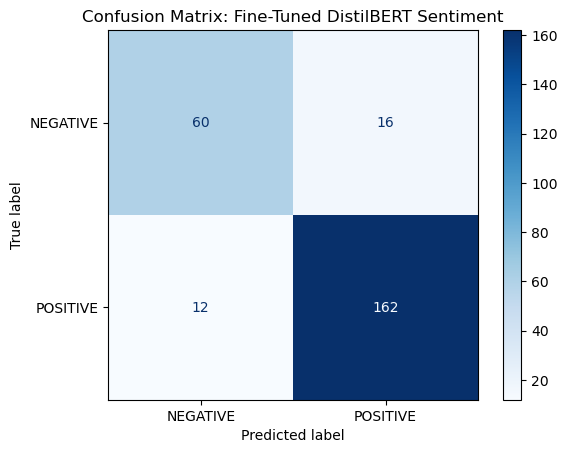

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = trainer.predict(tokenized_datasets['test'])
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NEGATIVE', 'POSITIVE'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Fine-Tuned DistilBERT Sentiment')
plt.show()


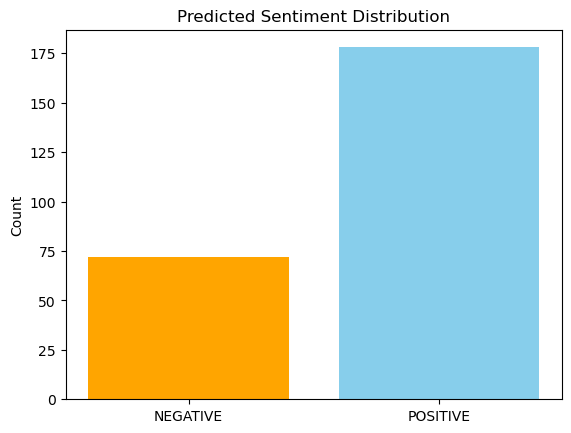

In [80]:
import numpy as np

unique, counts = np.unique(y_pred, return_counts=True)
plt.bar(['NEGATIVE', 'POSITIVE'], counts, color=['orange', 'skyblue'])
plt.ylabel('Count')
plt.title('Predicted Sentiment Distribution')
plt.show()


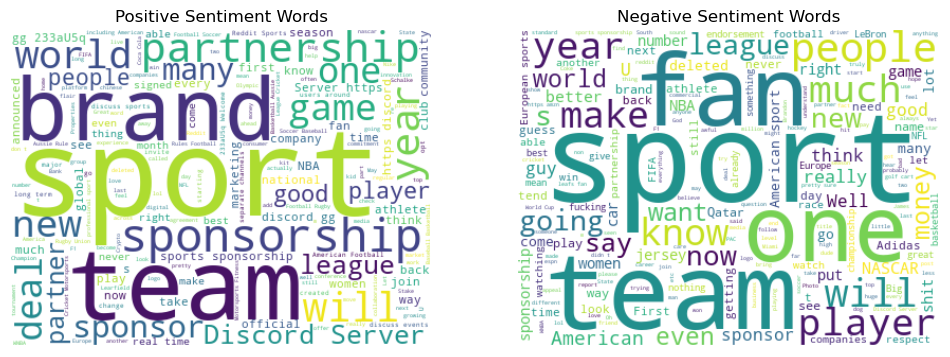

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

test_df = pd.DataFrame(tokenized_datasets['test'])

positive_text = ' '.join(test_df[test_df['label'] == 1]['text'].dropna().astype(str))
negative_text = ' '.join(test_df[test_df['label'] == 0]['text'].dropna().astype(str))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
wc_pos = WordCloud(width=400, height=300, background_color='white').generate(positive_text)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Words')

plt.subplot(1,2,2)
wc_neg = WordCloud(width=400, height=300, background_color='white').generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Words')

plt.show()
